In [2]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from tqdm.notebook import tqdm 

import tqdm as notebook_tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Basic Concepts

## White Noise

**Definition**: a time series is characterized as **white noise** when it 
consists of a sequence of uncorrelated random variables, commonly modeled as 
Gaussian (normal) random variables:

$$
x_t = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observations*:

* **Mean**: The series has a mean of **zero**.
* **Constant Variance**: The variance of the series remains constant and finite 
over time.
* **No Autocorrelation**: There is no predictable pattern or trend in the series.
Each value is statistically independent of other values, implying no correlation 
between past, present, and future values in the series.



## Random Walk

**Definition**: A time series is characterized as following a **random walk** if, 
and only if, the difference between its consecutive values (i.e., the variation 
at each time step) constitutes *white noise*. 

$$
x_t - x_{t-1} = \epsilon_t \\
\epsilon_t \sim N(0, \sigma)
$$

*Observation*: This implies that the changes in the series from one period to the 
next are entirely random and unpredictable, with no discernible pattern or trend, 
meaning that *each change* is **independent** of *past changes*.

# Basic Structural Time Series Model

**Definition** - the **Basic Structural Model** is a framework in time series 
analysis that decomposes a time series into three distinct components: **trend**, 
**cycle**, and **noise**.

$$
y_t = \mu_t + \gamma_t + \epsilon_t
$$

* $\mu_t$: **trend** represents the long-term progression of the series.
* $\gamma_t$: **cycle** accounts for regular but not necessarily seasonal 
fluctuations in the time series.
* $\epsilon_t \sim N(0, \sigma_{\epsilon})$: This is the **random error**, the 
**noise** or the **irregular component** of the series.

## Trends
### Stochastic Trend

The **1-step changes in the trend** are modeled as **random walk** plus 
**white noise**:

$$
\mu_t - \mu_{t-1} = \beta_t + \xi_t \\
\beta_t - \beta_{t-1} = \eta_t
$$

Where:

$$
\xi_t \sim N(0, \sigma_{\mu}) \\
\eta_t \sim N(0, \sigma_{\beta})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1} + \beta_t, \sigma_{\mu}) \\
\beta_t \sim N(\beta_{t-1}, \sigma_{\beta})
$$

*Observation*
Here it is usual to distinguish between:
* **(Local) Level**, $\mu_t$: The baseline value of the series, representing its 
**long-term** average or trend.
* **(Local) Trend**, $\beta_t$: A component that captures the gradual, long-term 
movement in the series. Unlike the level, which is more static, the trend is 
dynamic and can change over time, representing either an upward or downward 
direction in the data.


### Local Level Trend

If $\beta_0 = 0$ and $\sigma_{\beta} = 0$, the stochastic trend is called
*Local Level Trend*.

The **trend** is a **random walk** (equivalent to: "the **1-step changes** in the
trend are modeled as **white noise**"): 

$$
\mu_t - \mu_{t-1} = \xi_t
$$

With:

$$
\xi_t \sim N(0, \sigma_{\mu})
$$

Alternatively:

$$
\mu_t \sim N(\mu_{t-1}, \sigma_{\mu})
$$


## Cycles

# Simulation

In [4]:
import numpy as np
import pandas as pd

def stochastic_trend(
        rng, 
        N = 100, 
        sigma_local_trend = 1, 
        local_trend_0 = 1, 
        sigma_local_level = 1, 
        local_level_0 = 100
        ):
    """Simulate a stochastic trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """
    # local trend is a random walk
    diff_local_trend = rng.normal(0, sigma_local_trend, N)
    local_trend      = np.cumsum(diff_local_trend) + local_trend_0

    # local level is the local trend plus noise
    diff_local_level = rng.normal(local_trend, sigma_local_level, N)
    local_level      = np.cumsum(diff_local_level) + local_level_0

    # dataframe with t = 1:N, local_trend, local_level
    df = pd.DataFrame(
        {
            "t": np.arange(1, N + 1),
            "local_trend": local_trend,
            "local_level": local_level,
        }
    )
    return df

def plot_stochastic_trend(df):
    """plot local_trend and local_level vs t, each with a different y-axis

    Args:
        df (_type_): _description_
    """
    # plot local_trend and local_level vs t, each with a different y-axis
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    df.plot(x="t", y=["local_trend"], ax=ax1, alpha=0.5)
    df.plot(x="t", y=["local_level"], ax=ax2, alpha=0.5, color="C1")

    # Add y-axis labels
    ax1.set_ylabel("local_trend")
    ax2.set_ylabel("local_level")

    # Add a legend
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Add a title
    plt.title("Local Trend and Local Level")

    # Add horizontal dotted line at local_trend = 0
    ax1.axhline(0, linestyle="--", color="black", alpha=0.5)

    fig.tight_layout()
    plt.show()

def local_level_trend(
        rng, 
        N = 100, 
        sigma = 1, 
        level_0 = 100
        ):
    """simulate a local level trend

    Args:
        rng (_type_): _description_
        N (int, optional): _description_. Defaults to 100.
        sigma_local_trend (int, optional): _description_. Defaults to 1.
        sigma_local_level (int, optional): _description_. Defaults to 1.
        local_level_0 (int, optional): _description_. Defaults to 100.
        local_trend_0 (int, optional): _description_. Defaults to 1.
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = 0, 
        sigma_local_level = sigma, 
        local_level_0 = level_0
    )

    return df

def deterministic_trend(
        rng,
        N = 100,
        slope = 1,
        intercept = 100
):
    """simulate a deterministic trend
    """

    df = stochastic_trend(
        rng, 
        N = N, 
        sigma_local_trend = 0, 
        local_trend_0 = slope, 
        sigma_local_level = 0, 
        local_level_0 = intercept
    )

    return df



In [5]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

## Stochastic Trend

C:\Users\migue\AppData\Local\Temp\ipykernel_24292\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


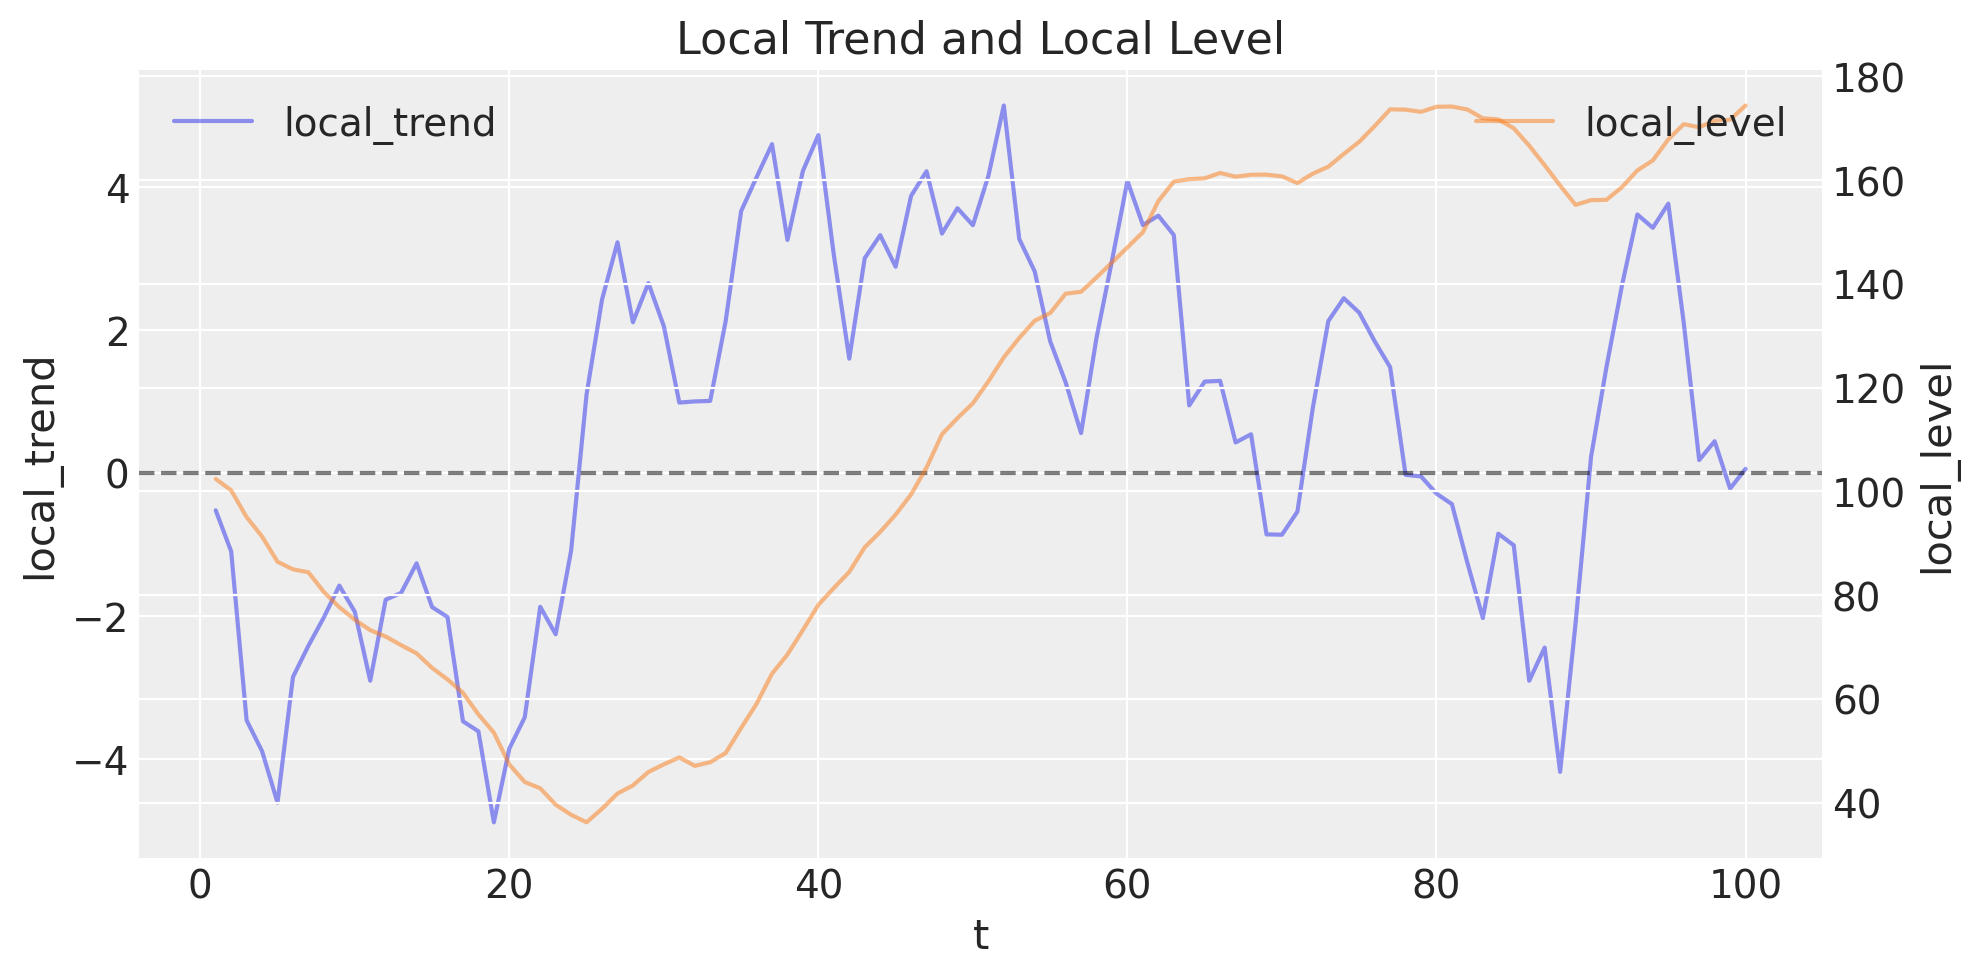

In [6]:
df_stoch_trend = stochastic_trend(
    rng, 
    N = 100, 
    sigma_local_trend = 1, 
    local_trend_0 = 1, 
    sigma_local_level = 1, 
    local_level_0 = 100
    )

plot_stochastic_trend(df_stoch_trend)

C:\Users\migue\AppData\Local\Temp\ipykernel_24292\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


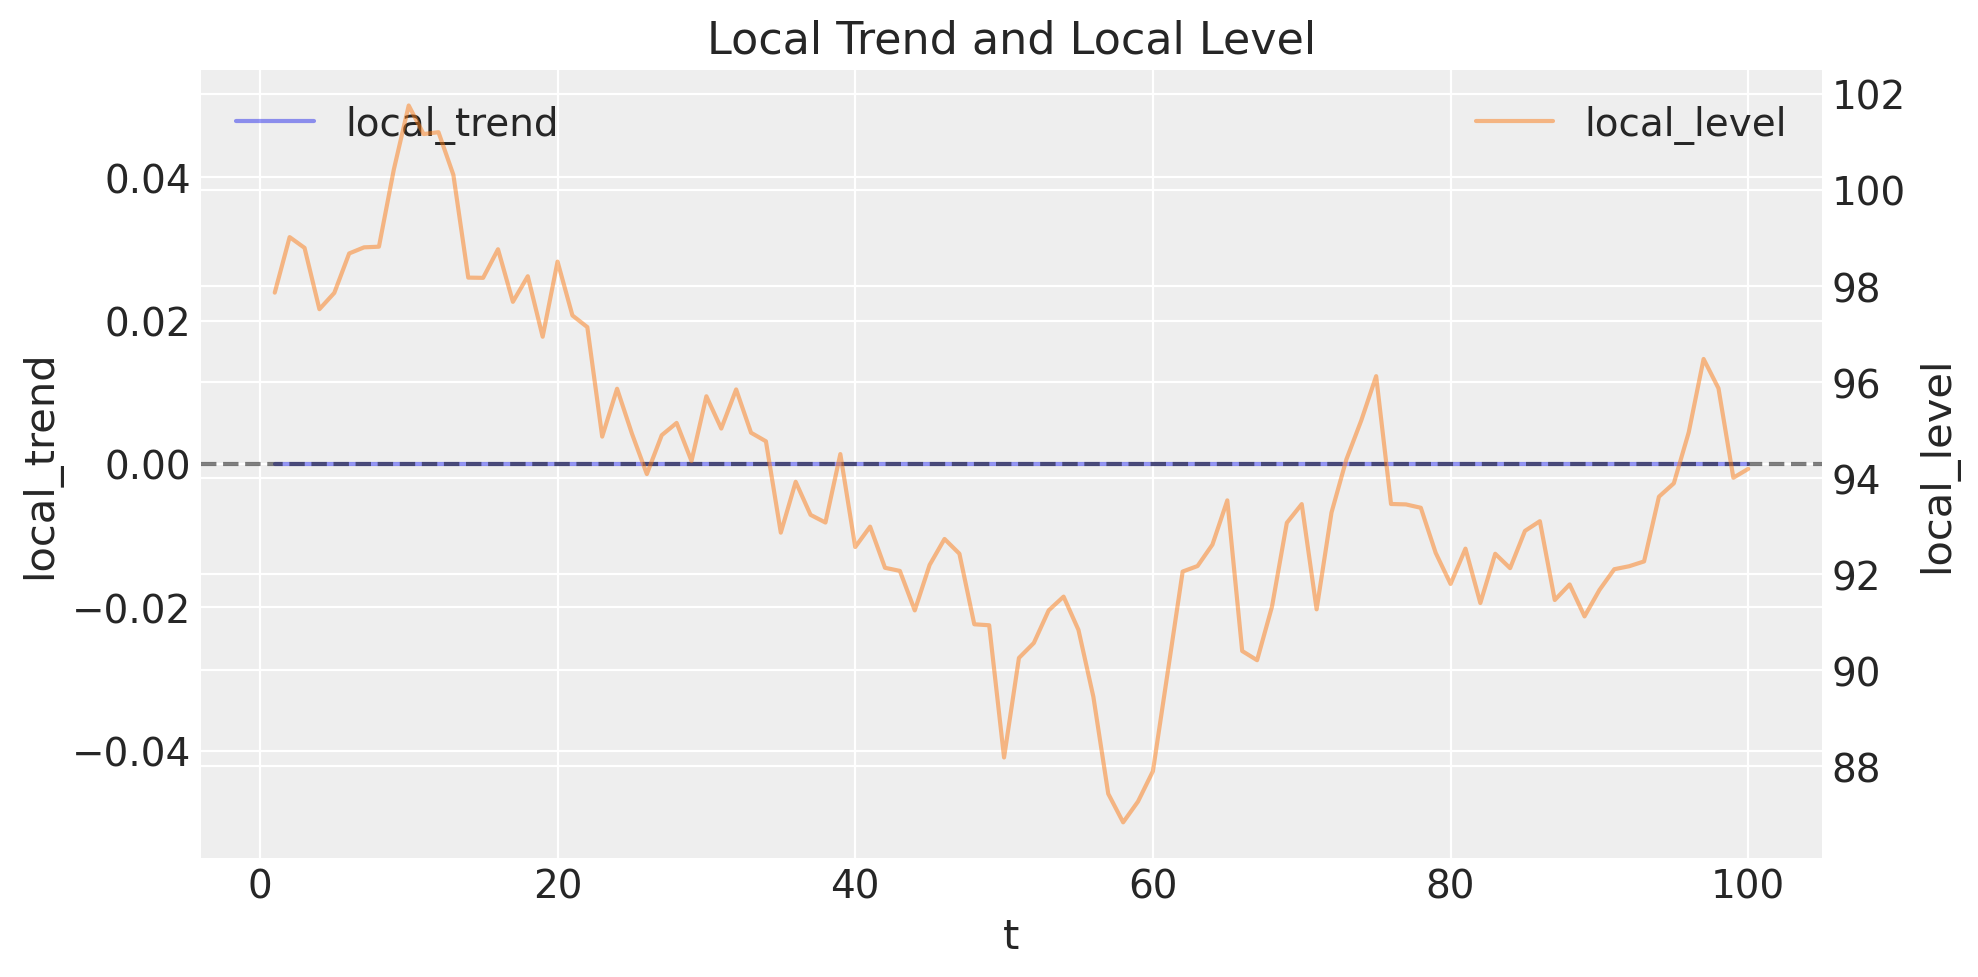

In [8]:
df_local_level_trend = local_level_trend(
    rng, 
    N = 100, 
    sigma = 1, 
    level_0 = 100
    )

plot_stochastic_trend(df_local_level_trend)

C:\Users\mcondedesimon\AppData\Local\Temp\ipykernel_5080\2552559127.py:69: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


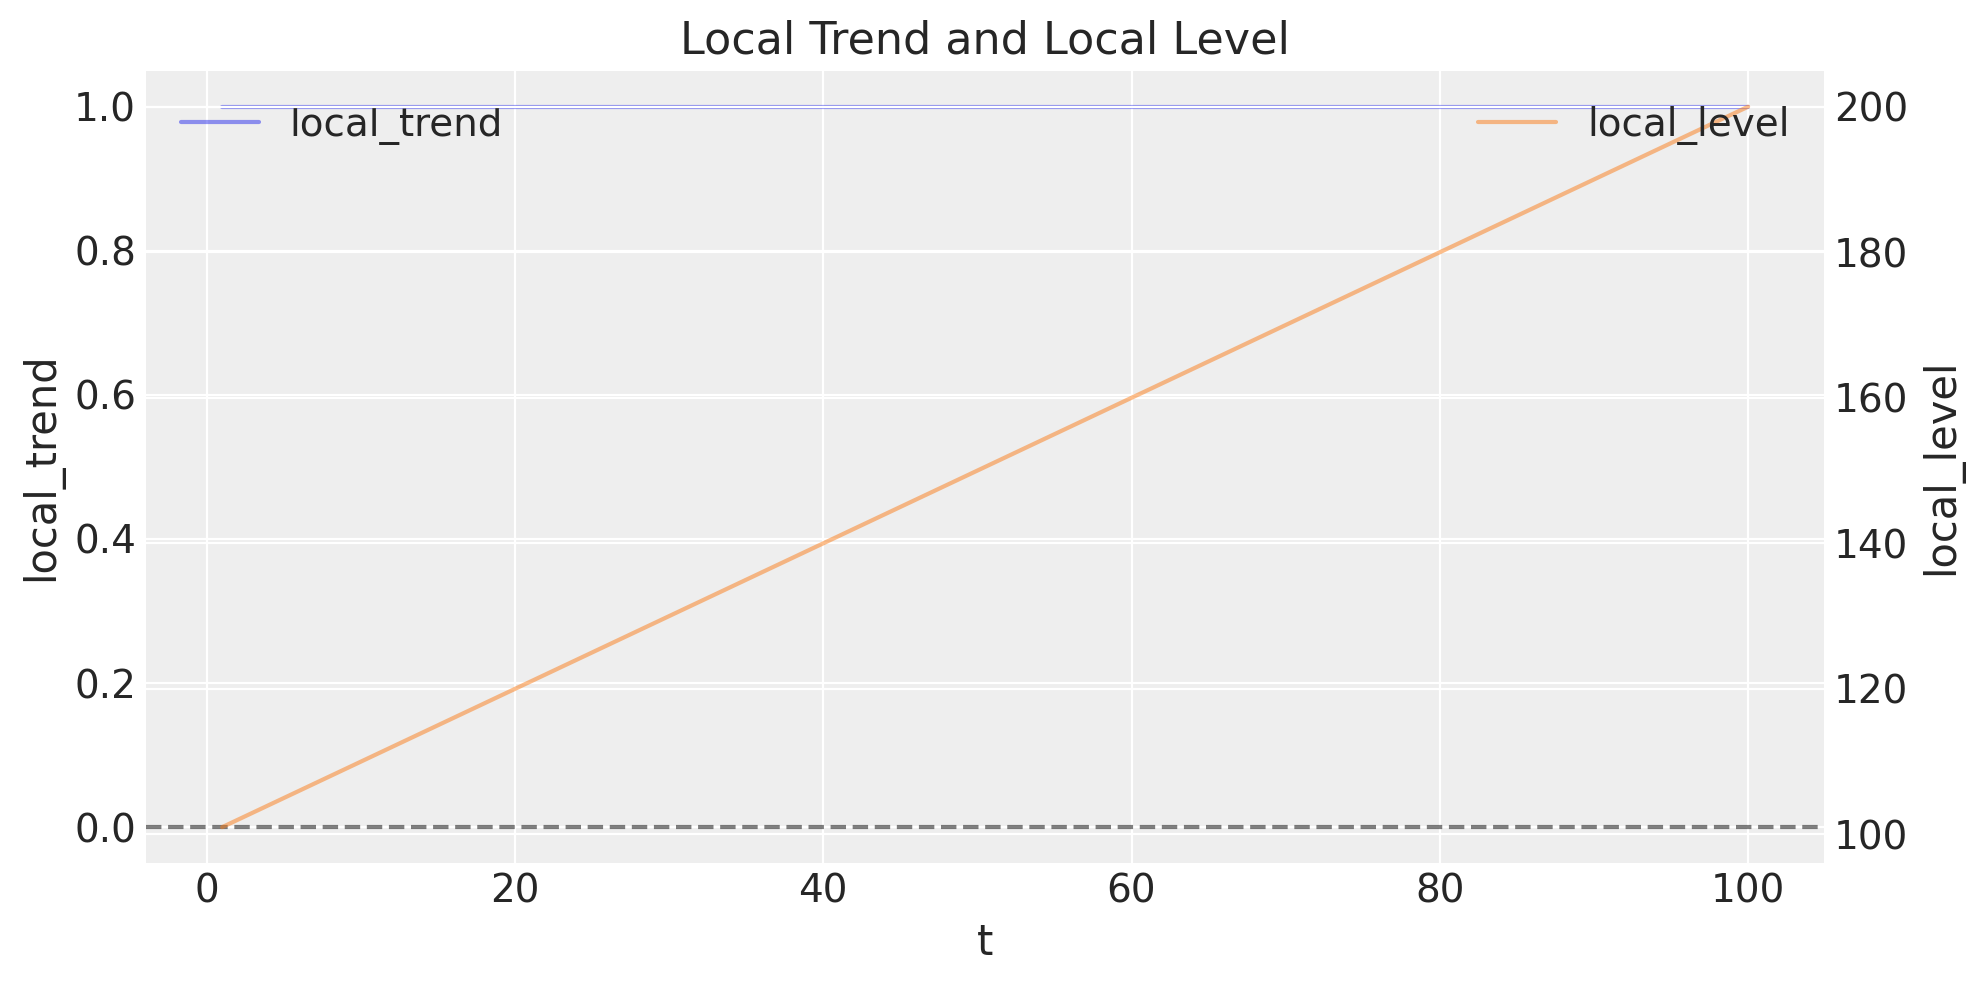

In [7]:
df_deterministic_trend = deterministic_trend(
    rng, 
    N = 100, 
    slope = 1, 
    intercept = 100
    )

plot_stochastic_trend(df_deterministic_trend)

### Cycles

In [14]:
# Dataframe con columna 'fecha' desde 2021-01-01 hasta 2023-11-30, con frecuencia semanal
df = pd.DataFrame(
    {
        "fecha": pd.date_range(start="2021-01-01", end="2023-11-30", freq="D")
    }
)

# Agregamos columna 't' con el número de semana
df["t"] = df.index + 1

# Agregamos el dia de la semana como string
df["dia_semana"] = df["fecha"].dt.day_name()

# Agregamos el dia de la semana como numero
df["dia_semana_num"] = df["fecha"].dt.dayofweek + 1

df.head()

,fecha,t,dia_semana,dia_semana_num
0,2021-01-01,1,Friday,5
1,2021-01-02,2,Saturday,6
2,2021-01-03,3,Sunday,7
3,2021-01-04,4,Monday,1
4,2021-01-05,5,Tuesday,2


In [30]:
def make_fourier_features(df, date_var_name, n_order=10, period=365.25):
    """
    Generate Fourier features based on a given date variable in a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the date variable.
        date_var_name (str): The name of the date variable column in the DataFrame.
        n_order (int, optional): The number of Fourier orders to generate. Defaults to 10.
        period (float, optional): The period of the Fourier series. Defaults to 365.25.

    Returns:
        pandas.DataFrame: A DataFrame containing the Fourier features.
    """
    # Calculate the periods based on the date variable
    periods = (df[date_var_name] - pd.Timestamp("1900-01-01")).dt.days / period

    # Generate the Fourier features using sine and cosine functions
    fourier_features = pd.DataFrame(
        {
            f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
            for order in range(1, n_order + 1)
            for func in ("sin", "cos")
        }
    )

    return fourier_features

<Axes: xlabel='fecha'>

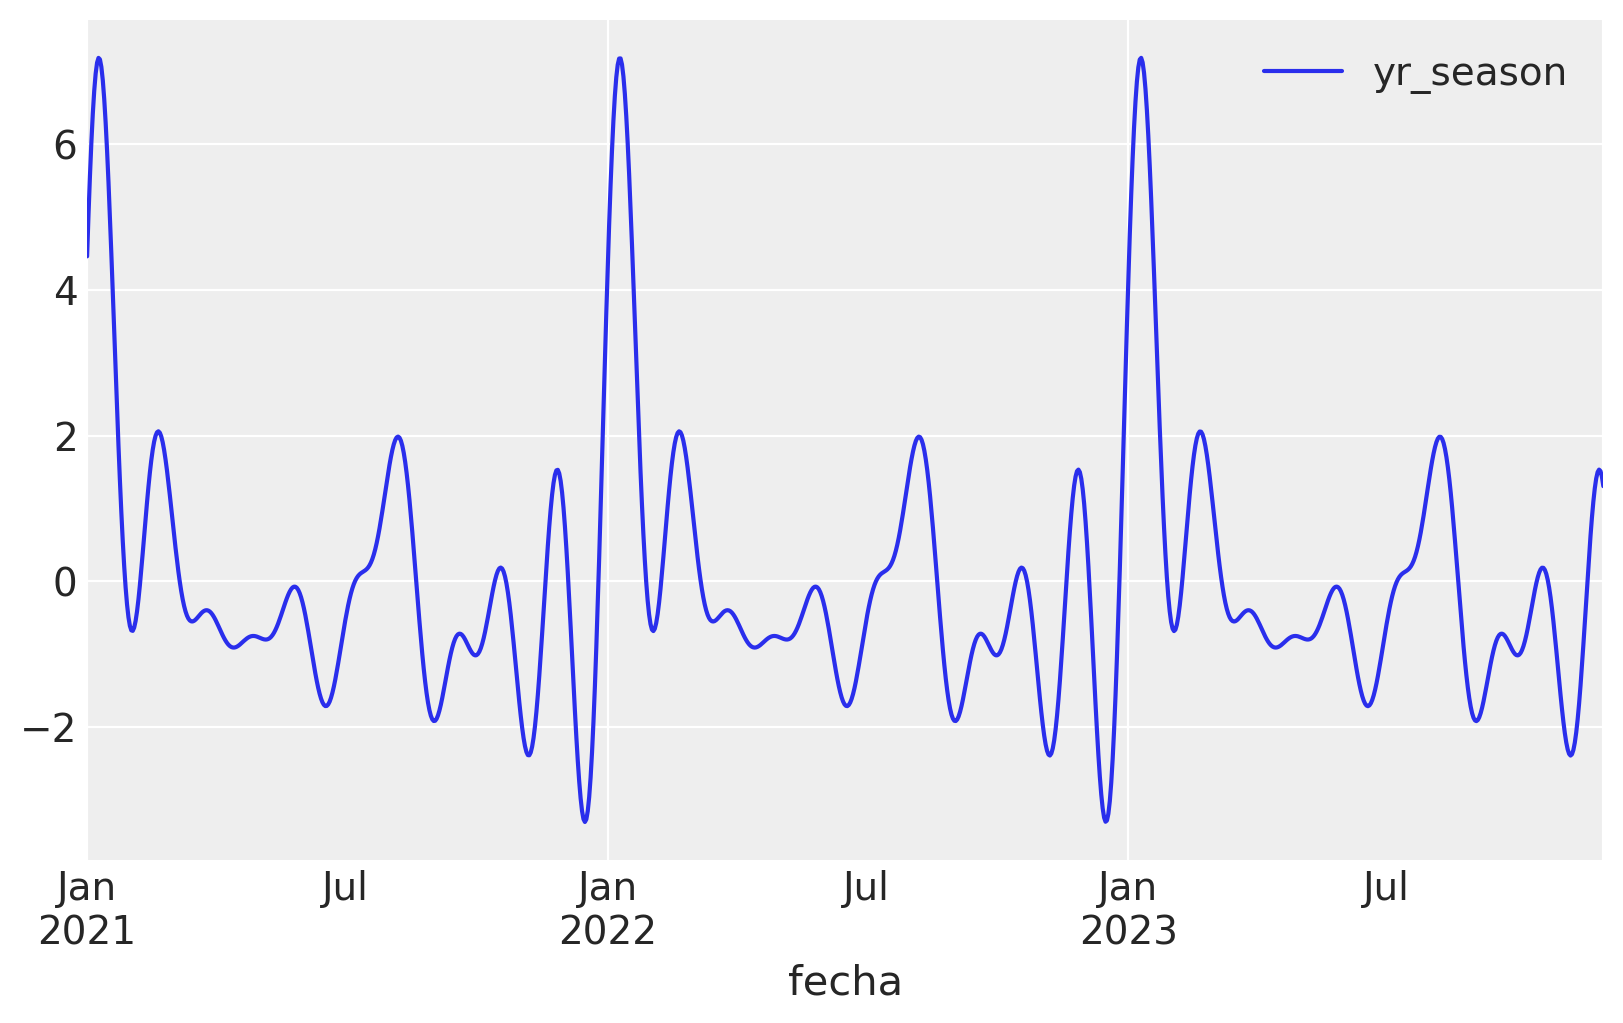

In [31]:
fourier_features = make_fourier_features(df, "fecha", n_order=10, period=365.25)

# genera un numpy array con shape (1, df.shape[0]) yllénalo con valores aleatorios
fourier_coefs = np.array(rng.uniform(0, 1, fourier_features.shape[1]))

# Multiplica matricialmente las fourier_features por four_coefs
df['yr_season'] = np.dot(fourier_features, fourier_coefs)

df.plot(x="fecha", y=["yr_season"])


# Modeling

In [8]:
df = df_stoch_trend.assign(y = lambda x: x.local_level + rng.normal(0, 1, 100))

In [9]:
df.head()

,t,local_trend,local_level,y
0,1,-0.521628,102.402626,103.153368
1,2,-1.095988,100.213918,100.536882
2,3,-3.458094,95.041352,94.893881
3,4,-3.890317,91.306045,91.347738
4,5,-4.609461,86.437916,87.125496


<Axes: xlabel='t'>

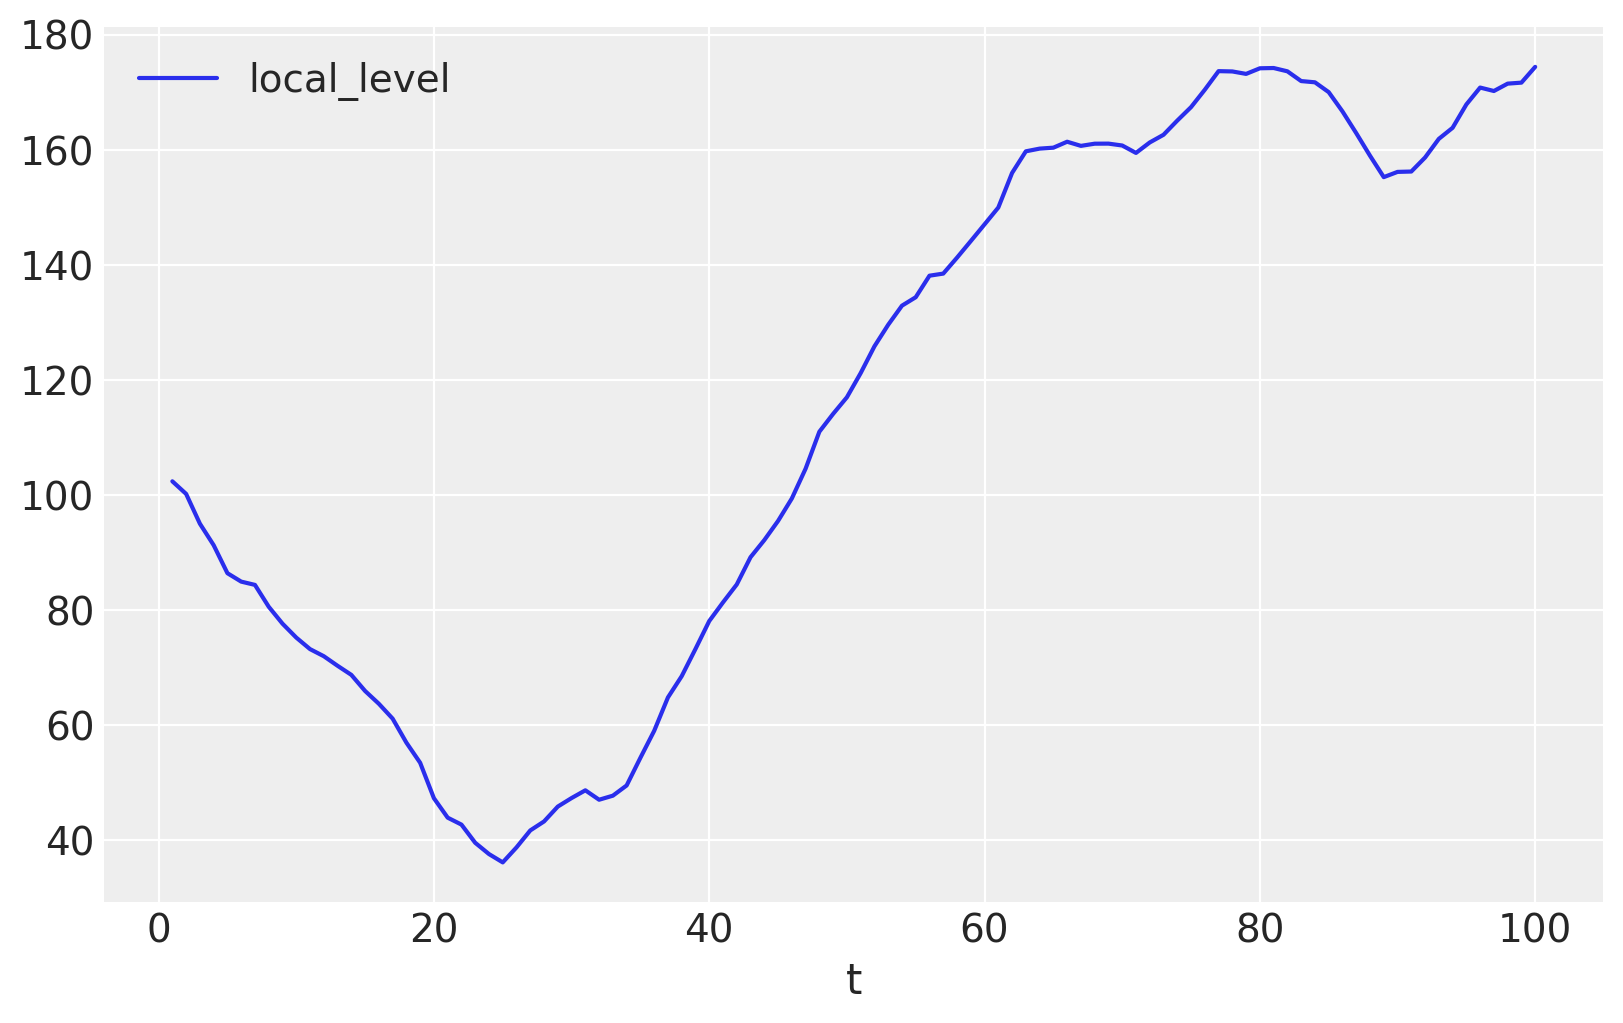

In [10]:
df.plot(x="t", y=["local_level"])

## 0 - Scale the data

In [11]:
t = df["t"].to_numpy()

# Max-min scaling
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

In [12]:
# Next, for the target variable, we divide by the maximum. We do this, rather 
# than standardising, so that the sign of the 
# observations in unchanged - this will be necessary for the seasonality 
# component to work properly later on.
y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

## 1 - Model

In [40]:
np.sqrt(1/y_max)

0.07547654174510139

In [61]:
1/0.05

20.0

In [62]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=False) as stochastic_trend_model:

    sigma_local_trend = pm.Exponential("sigma_local_trend", lam=20)
    sigma_local_level = pm.Exponential("sigma_local_level", lam=20)
    sigma             = pm.Exponential("sigma", lam=.1)

    local_trend_0    = pm.Normal("local_trend_0", mu=0, sigma=1)
    diff_local_trend = pm.Normal("diff_local_trend", mu=0, sigma=sigma_local_trend, dims="n_obs")
    local_trend      = pm.Deterministic("local_trend", diff_local_trend.cumsum() + local_trend_0, dims="n_obs")
    
    local_level_0    = pm.Normal("local_level_0", mu=0, sigma=1)
    diff_local_level = pm.Normal("diff_local_level", mu=local_trend, sigma=sigma_local_level, dims="n_obs")
    local_level      = pm.Deterministic("local_level", diff_local_level.cumsum() + local_level_0, dims="n_obs")

    y_obs = pm.Normal("y_obs", mu=local_level, sigma=sigma, dims="n_obs", observed=y)

    stochastic_trend_prior = pm.sample_prior_predictive()

Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y_obs]


In [14]:
stochastic_trend_prior

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

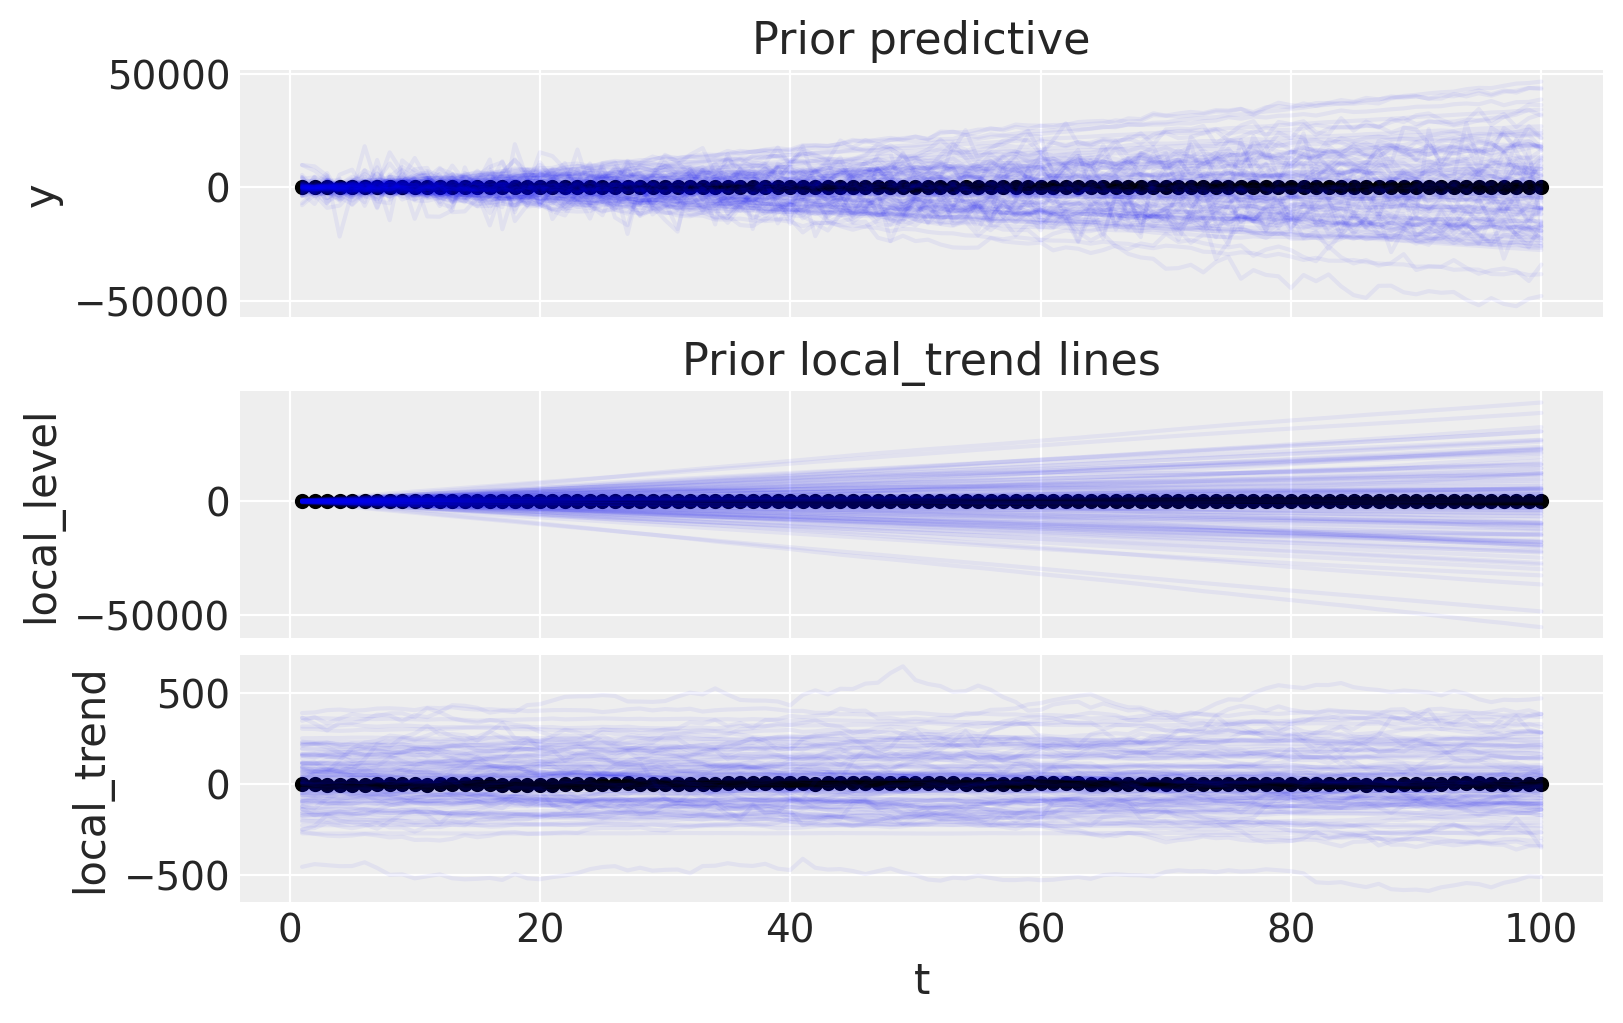

In [63]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [91]:
with stochastic_trend_model:
    # inference data, trace, posterior
    idata = pm.sample(
        return_inferencedata=True, 
        target_accept=0.9,
        draws=12000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True}
        )
    # ppc predictive check
    ppc = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:02.261993
Sampling...


Compiling.. :   0%|          | 0/13000 [00:00<?, ?it/s]











Running chain 0:   0%|          | 0/13000 [00:05<?, ?it/s]









Running chain 0:   5%|▌         | 650/13000 [00:09<01:09, 176.90it/s]




Running chain 0:  10%|█         | 1300/13000 [00:12<01:03, 184.19it/s]





Running chain 0:  15%|█▌        | 1950/13000 [00:15<00:57, 192.57it/s]





Running chain 0:  20%|██        | 2600/13000 [00:20<01:03, 163.14it/s]





Running chain 0:  25%|██▌       | 3250/13000 [00:25<01:05, 149.81it/s]



Running chain 0:  30%|███       | 3900/13000 [00:30<01:02, 145.55it/s]





Running chain 0:  35%|███▌      | 4550/13000 [00:34<00:57, 146.02it/s]








Running chain 0:  40%|████      | 5200/13000 [00:40<00:56, 138.11it/s]




Running chain 0:  45%|████▌     | 5850/13000 [00:44<00:52, 137.42it/s]





Running chain 0:  50%|█████     | 6500/13000 [00:49<00:46, 138.33it/s]



Running chain 0:  55%|█████▌    | 7150/13000 [00:53<00:41, 140.50it/s]





Running chain 0:  60%|██████    |

Sampling time =  0:01:50.895607
Transforming variables...
Transformation time =  0:00:01.044797
Computing Log Likelihood...
Log Likelihood time =  0:00:01.130090


Sampling: [y_obs]


In [92]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [93]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

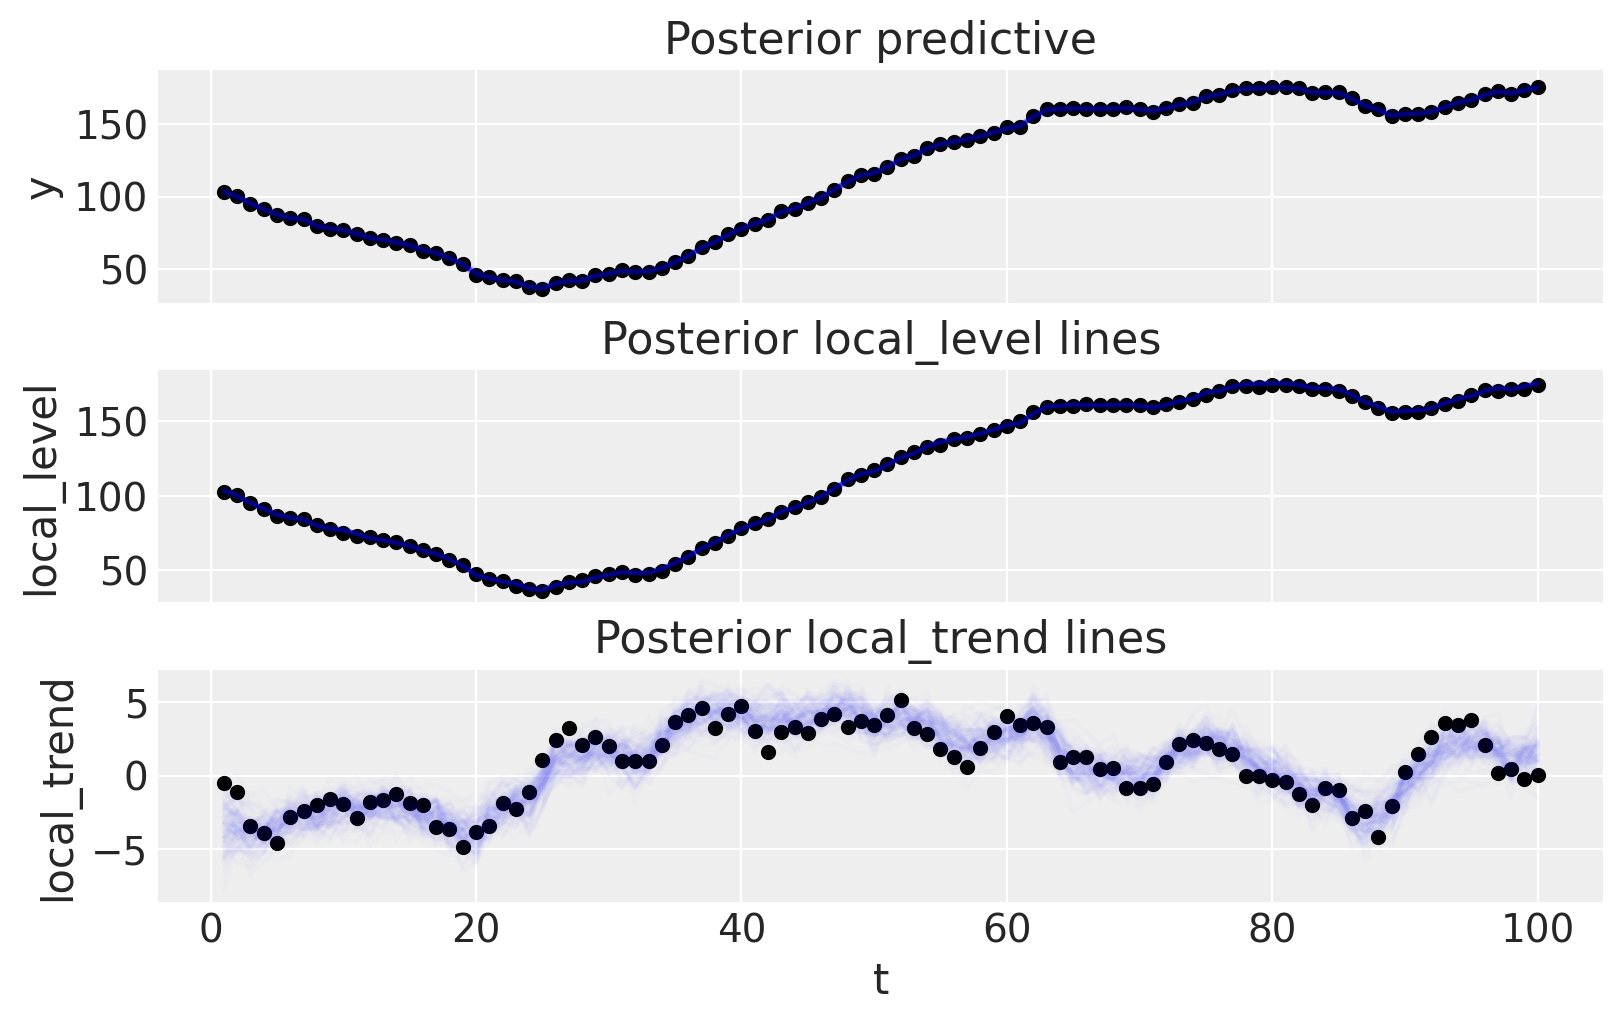

In [94]:

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

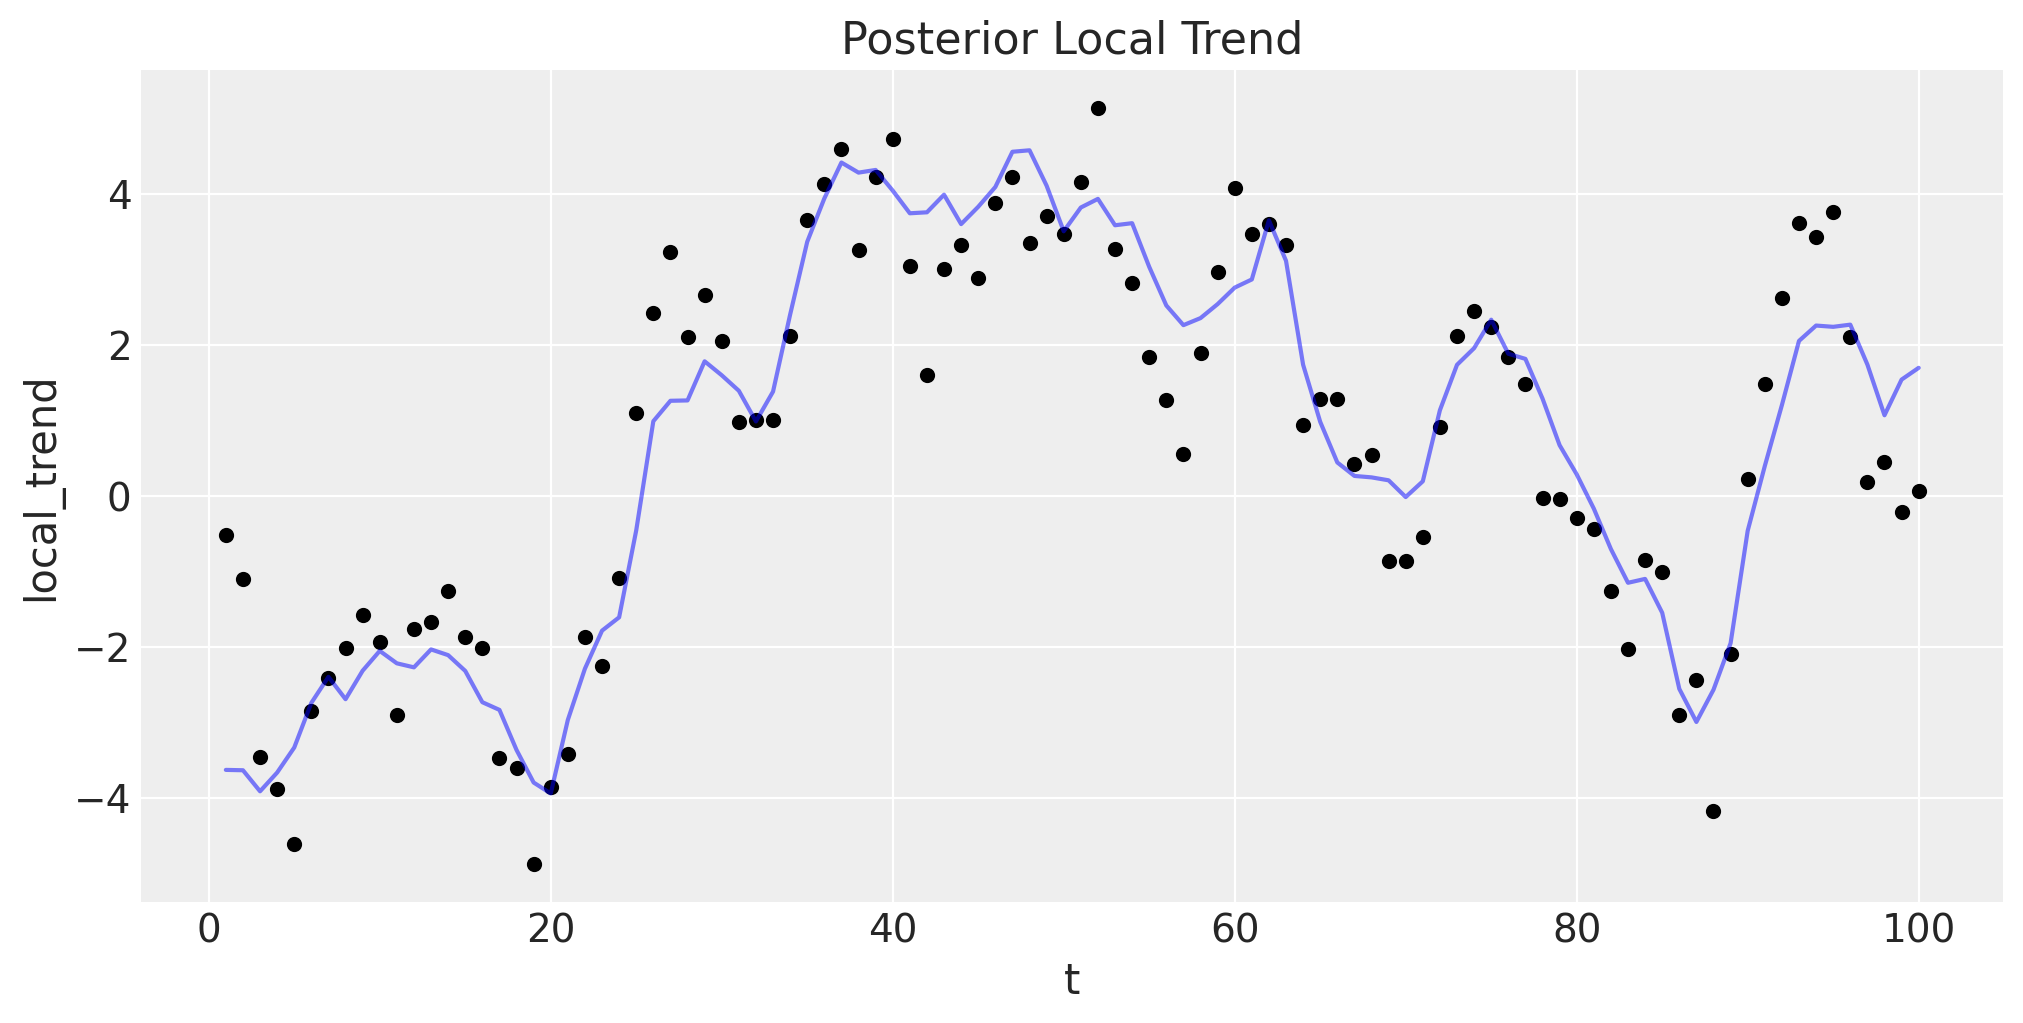

In [95]:
posterior_avg_trend = y_max*idata.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [98]:
az.summary(idata, var_names=['sigma_local_trend', 'sigma_local_level', 'local_trend_0', 'local_level_0', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_local_trend,0.006,0.001,0.003,0.008,0.0,0.0,2019.0,5821.0,1.00
sigma_local_level,0.008,0.003,0.003,0.012,0.0,0.0,558.0,976.0,1.01
local_trend_0,-0.021,0.010,-0.041,-0.002,0.0,0.0,14430.0,26324.0,1.00
local_level_0,0.609,0.013,0.584,0.634,0.0,0.0,7116.0,4541.0,1.00
sigma,0.004,0.002,0.001,0.007,0.0,0.0,358.0,170.0,1.02


In [99]:
az.summary(ppc, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],0.588,0.006,0.577,0.600,0.0,0.0,55958.0,18718.0,1.0
y_obs[1],0.570,0.006,0.558,0.581,0.0,0.0,13878.0,15423.0,1.0
y_obs[2],0.542,0.006,0.531,0.553,0.0,0.0,42940.0,21561.0,1.0
y_obs[3],0.520,0.006,0.509,0.531,0.0,0.0,61135.0,25581.0,1.0
y_obs[4],0.498,0.006,0.487,0.510,0.0,0.0,19589.0,18073.0,1.0
...,...,...,...,...,...,...,...,...,...
y_obs[95],0.970,0.006,0.959,0.982,0.0,0.0,23286.0,15930.0,1.0
y_obs[96],0.982,0.006,0.970,0.993,0.0,0.0,3597.0,12653.0,1.0
y_obs[97],0.976,0.006,0.965,0.989,0.0,0.0,3358.0,11524.0,1.0
y_obs[98],0.988,0.006,0.977,1.000,0.0,0.0,60390.0,26316.0,1.0


In [29]:
0.004 * 940

3.7600000000000002

### Alternativa que no funciona

In [114]:
coords = {'n_obs': df.index}

with pm.Model(coords=coords, check_bounds=True) as stochastic_trend_model_2:

    # Define the standard deviation for the trend, level and signal noises
    sigma_local_trend = pm.HalfNormal('sigma_local_trend', sigma=20)
    sigma_local_level = pm.HalfNormal('sigma_local_level', sigma=20)
    sigma       = pm.HalfNormal('sigma', sigma=.1)

    # Define the Gaussian Random Walk for the trend
    local_trend = pm.GaussianRandomWalk(
        name  = 'local_trend', 
        sigma = sigma_local_trend, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        )

    # Define the level as the trend plus Gaussian noise
    local_level = pm.GaussianRandomWalk(
        name  = 'local_level', 
        # mu    = local_trend, # Este es el que da problemas
        sigma = sigma_local_level, 
        dims  = 'n_obs', 
        # init_dist = pm.Normal.dist(mu=0, sigma=1),
        ) + local_trend
    
    # Likelihood
    y_obs = pm.Normal(
        name     =  "y_obs", 
        mu       = local_level, 
        sigma    = sigma, 
        # dims     = "n_obs", 
        observed = y,
        )
    
    stochastic_trend_prior2 = pm.sample_prior_predictive()


c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\pymc\distributions\timeseries.py:293: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Sampling: [local_level, local_trend, sigma, sigma_local_level, sigma_local_trend, y_obs]


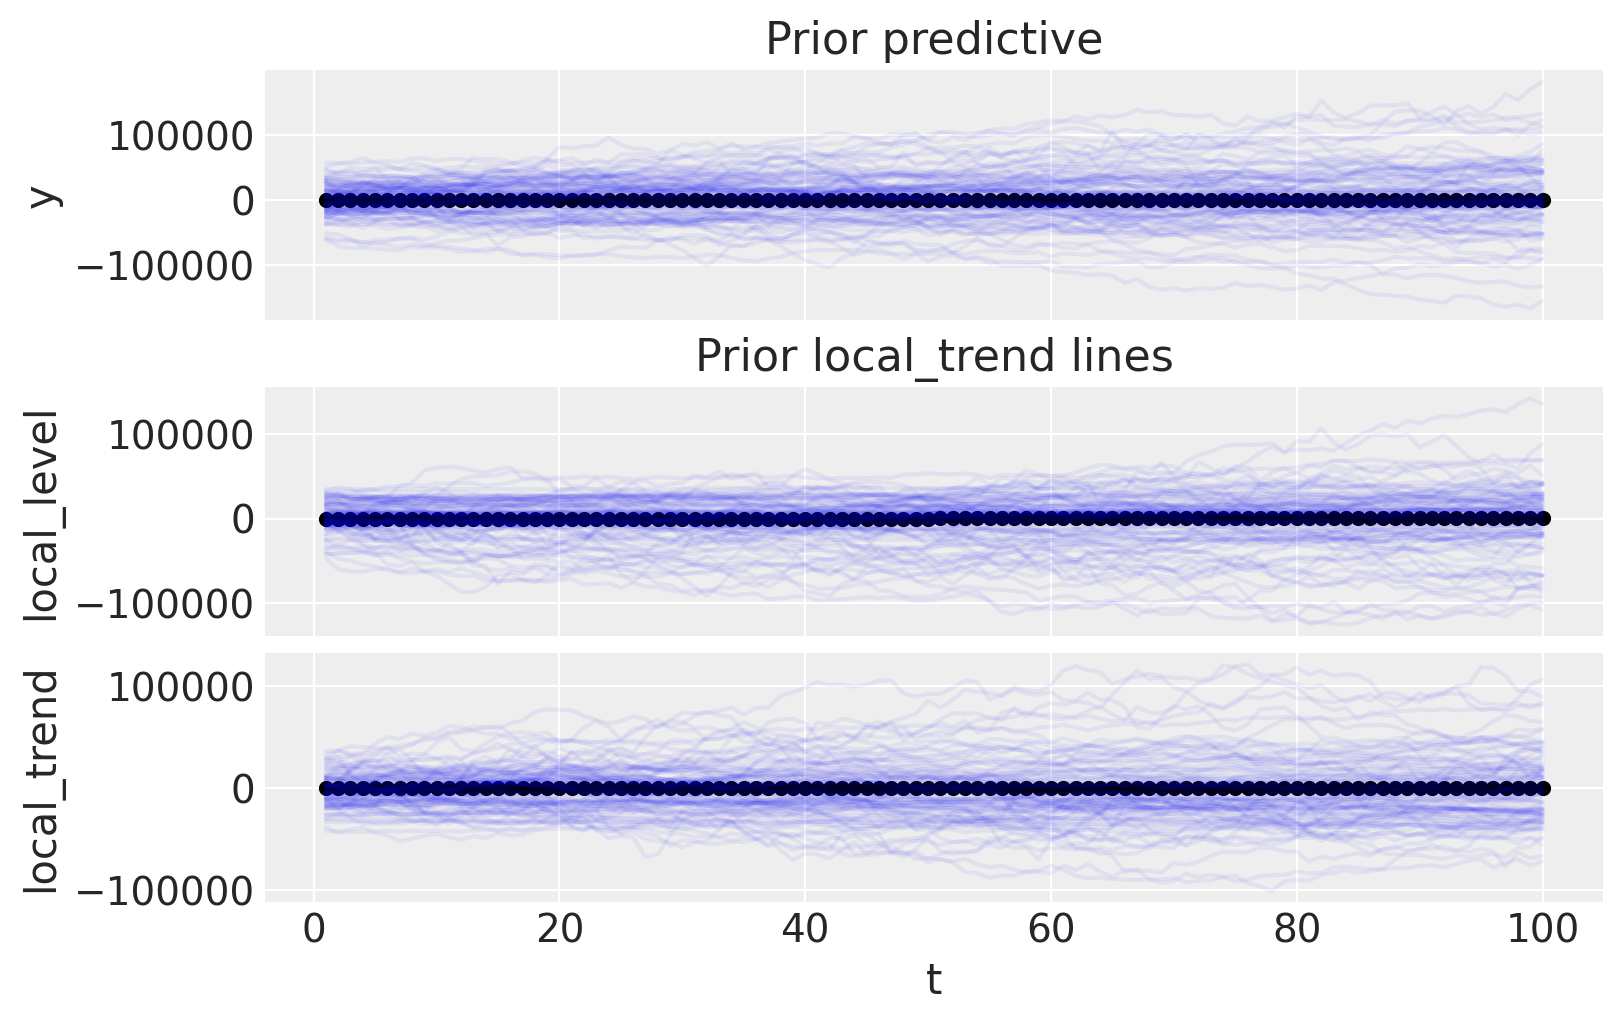

In [108]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior_predictive", num_samples=100)["y_obs"]
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")

ax[1].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Prior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(stochastic_trend_prior2, group="prior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[1].set_title("Prior local_trend lines");

In [115]:
RANDOM_SEED = 99999
rng = np.random.default_rng(RANDOM_SEED)

with stochastic_trend_model_2:
    idata2 = pm.sample(
        return_inferencedata=True, 
        # target_accept=0.9,
        draws=3000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
        idata_kwargs={"log_likelihood": True},
        )
    ppc2 = pm.sample_posterior_predictive(trace=idata2)

Compiling...
Compilation time =  0:00:05.095162
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]
















Running chain 0:   0%|          | 0/4000 [00:05<?, ?it/s]





Running chain 0:   5%|▌         | 200/4000 [00:05<00:12, 292.69it/s]




Running chain 0:  10%|█         | 400/4000 [00:06<00:14, 240.76it/s]





Running chain 0:  15%|█▌        | 600/4000 [00:07<00:16, 208.24it/s]





Running chain 0:  20%|██        | 800/4000 [00:09<00:18, 171.28it/s]





Running chain 0:  25%|██▌       | 1000/4000 [00:11<00:23, 129.44it/s]




Running chain 0:  30%|███       | 1200/4000 [00:12<00:20, 134.77it/s]


Running chain 0:  35%|███▌      | 1400/4000 [00:13<00:17, 152.30it/s]



Running chain 0:  40%|████      | 1600/4000 [00:15<00:15, 158.63it/s]

Running chain 0:  45%|████▌     | 1800/4000 [00:15<00:12, 179.27it/s]





Running chain 0:  50%|█████     | 2000/4000 [00:17<00:11, 175.92it/s]




Running chain 0:  55%|█████▌    | 2200/4000 [00:18<00:10, 178.04it/s]


Running chain 0:  60%|██████    | 2400/4000 [00:19<00:09, 17

Sampling time =  0:00:33.549584
Transforming variables...
Transformation time =  0:00:00.163611
Computing Log Likelihood...


Sampling: [y_obs]


Log Likelihood time =  0:00:00.441393


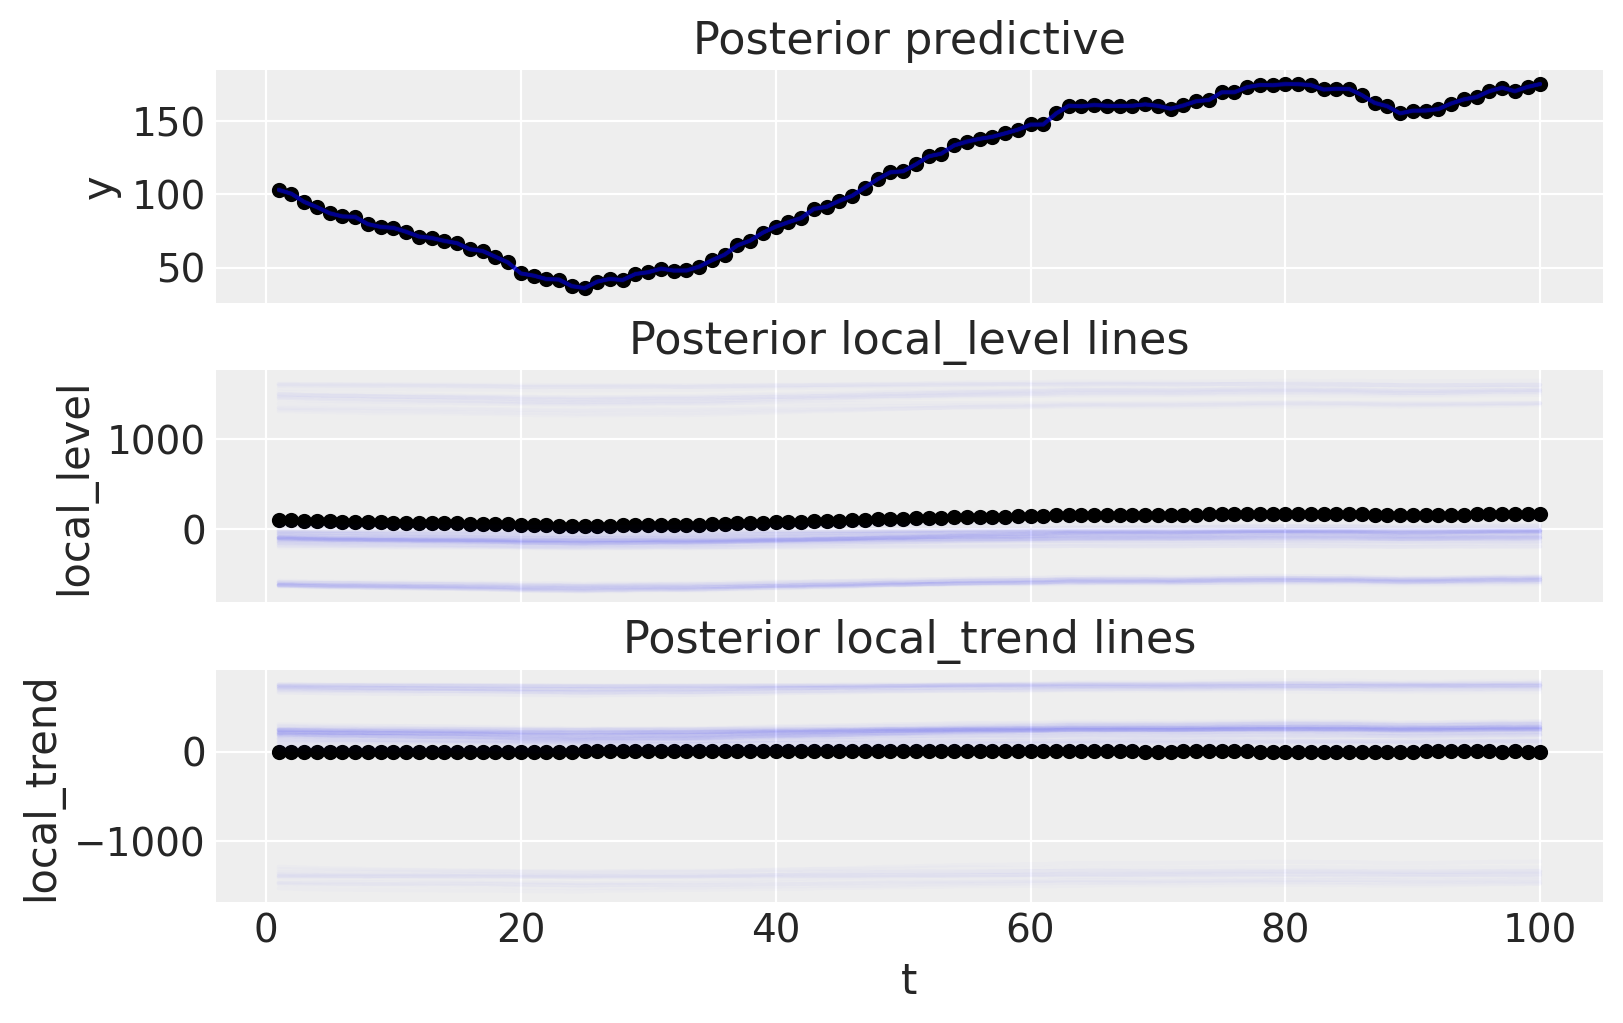

In [110]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    az.extract(ppc2, group="posterior_predictive", num_samples=100)["y_obs"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata2, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");

In [111]:
idata2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

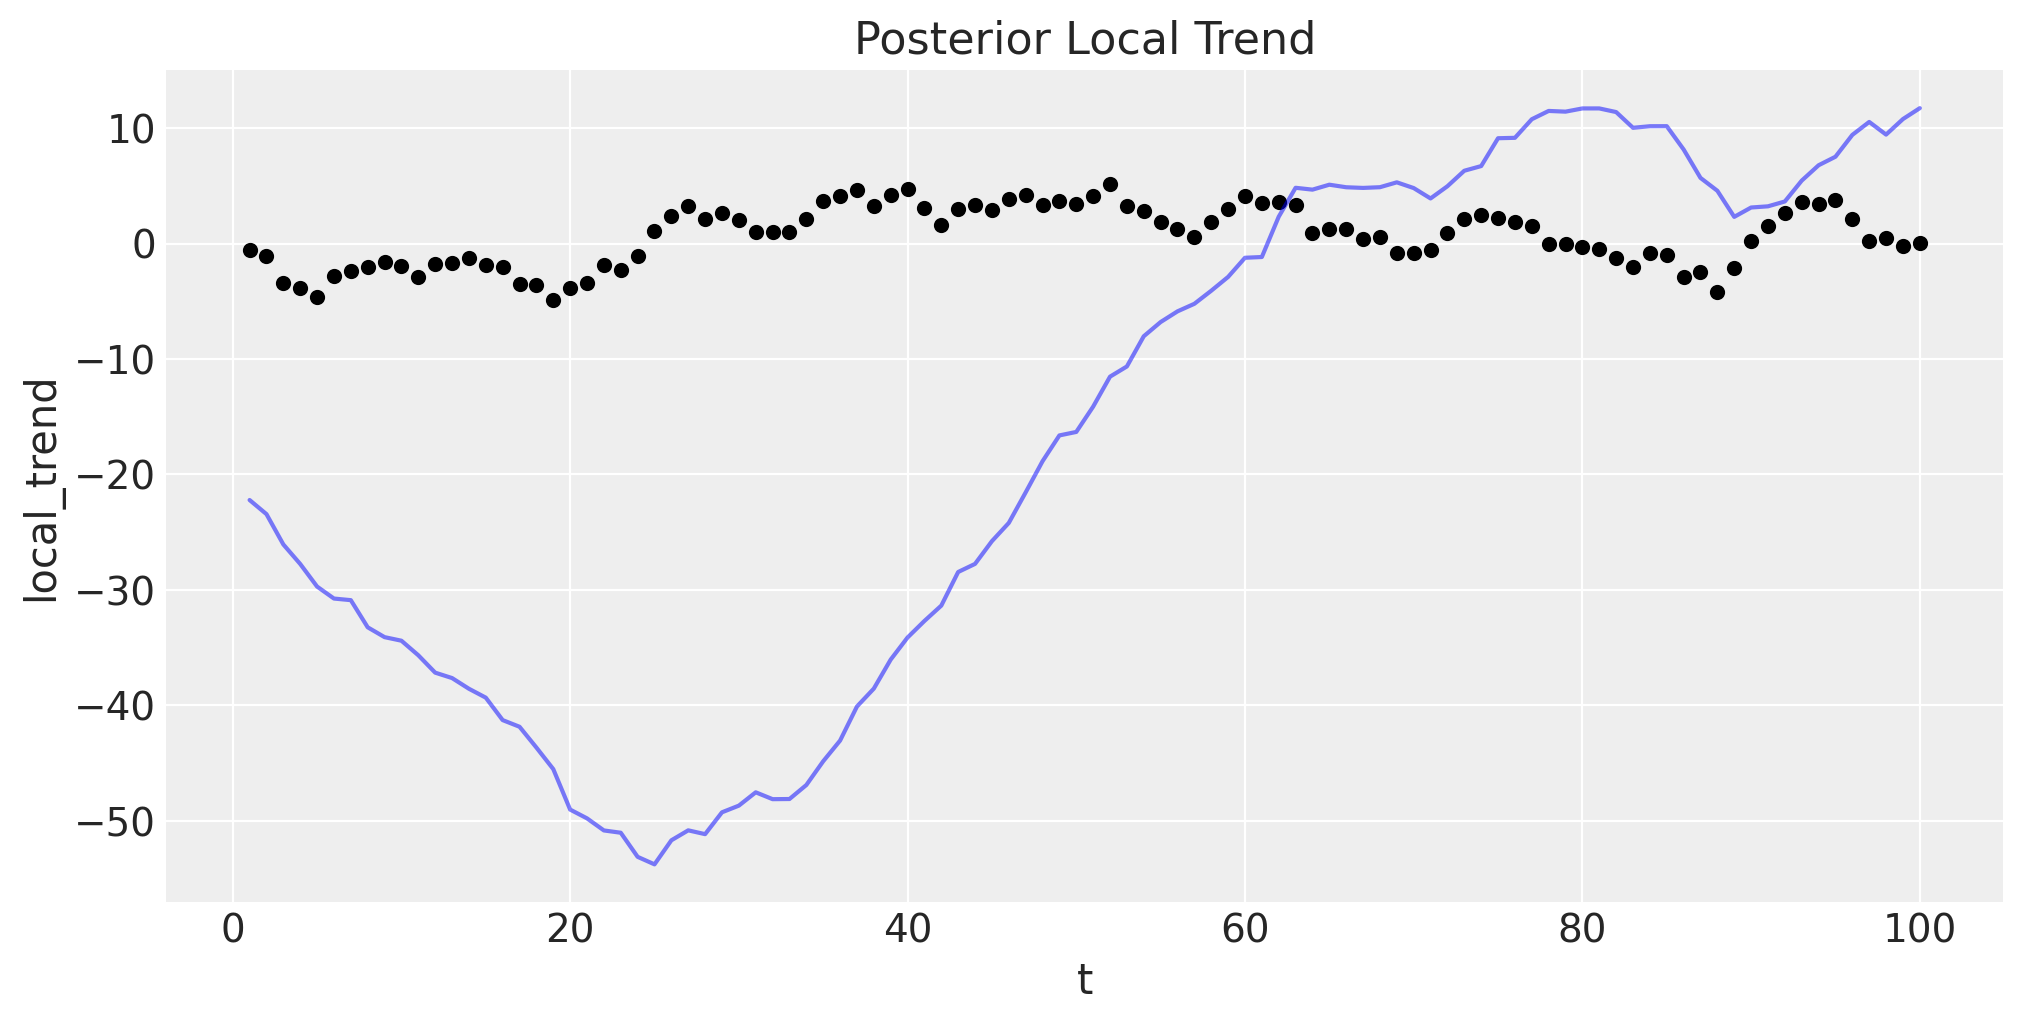

In [112]:
posterior_avg_trend2 = y_max*idata2.posterior['local_trend'].mean(dim=['chain', 'draw'])
posterior_avg_trend2

# plot ppc_avg_trend and y vs t
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["t"], posterior_avg_trend2, color="blue", alpha=0.5)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax)
ax.set_title("Posterior Local Trend")
ax.set_ylabel("local_trend")
ax.set_xlabel("t");

In [116]:
az.summary(idata2, var_names=['sigma_local_trend', 'sigma_local_level', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_local_trend,0.012,0.005,0.003,0.020,0.001,0.001,18.0,58.0,1.20
sigma_local_level,0.013,0.005,0.001,0.019,0.001,0.001,17.0,17.0,1.21
sigma,0.002,0.001,0.000,0.003,0.000,0.000,25.0,145.0,1.16


In [119]:
az.summary(ppc2, var_names=['y_obs'])

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\stats\stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_obs[0],0.587,0.003,0.582,0.592,0.0,0.0,14396.0,1939.0,1.05
y_obs[1],0.573,0.003,0.567,0.578,0.0,0.0,15152.0,1885.0,1.05
y_obs[2],0.541,0.003,0.536,0.546,0.0,0.0,15153.0,2273.0,1.04
y_obs[3],0.520,0.003,0.515,0.525,0.0,0.0,14361.0,2093.0,1.05
y_obs[4],0.496,0.003,0.491,0.502,0.0,0.0,14851.0,2099.0,1.04
...,...,...,...,...,...,...,...,...,...
y_obs[95],0.972,0.003,0.967,0.977,0.0,0.0,13903.0,2002.0,1.04
y_obs[96],0.986,0.003,0.980,0.991,0.0,0.0,13117.0,1737.0,1.04
y_obs[97],0.972,0.003,0.967,0.978,0.0,0.0,13816.0,1823.0,1.05
y_obs[98],0.988,0.003,0.983,0.993,0.0,0.0,14444.0,2272.0,1.05
